# Convolutional Neural Networks for Sentence Classification

## Abstract

> In this project I attempt to implement various approaches to classify sentences using convolutional neural networks (CNNs). Though I was not successful in implementing my desired model, the model I ultimately employed got better accuracy than was originally hoped for. I conclude with thoughts on possible directions for future projects.

## Background

[Implementing a CNN for Text Classification](http://www.wildml.com/2015/12/implementing-a-cnn-for-text-classification-in-tensorflow/). Britz, Denny. 2015.

[A Sensitivity Analysis of and (Practitioners’ Guide to) Convolutional
Neural Networks for Sentence Classification](http://arxiv.org/pdf/1510.03820v4.pdf). Zhang, Ye and Byron C. Wallace. 2016.

[Convolutional Neural Networks for Sentence Classification](http://arxiv.org/pdf/1408.5882v2.pdf). Kim, Yoon. 2014.

## General Architecture

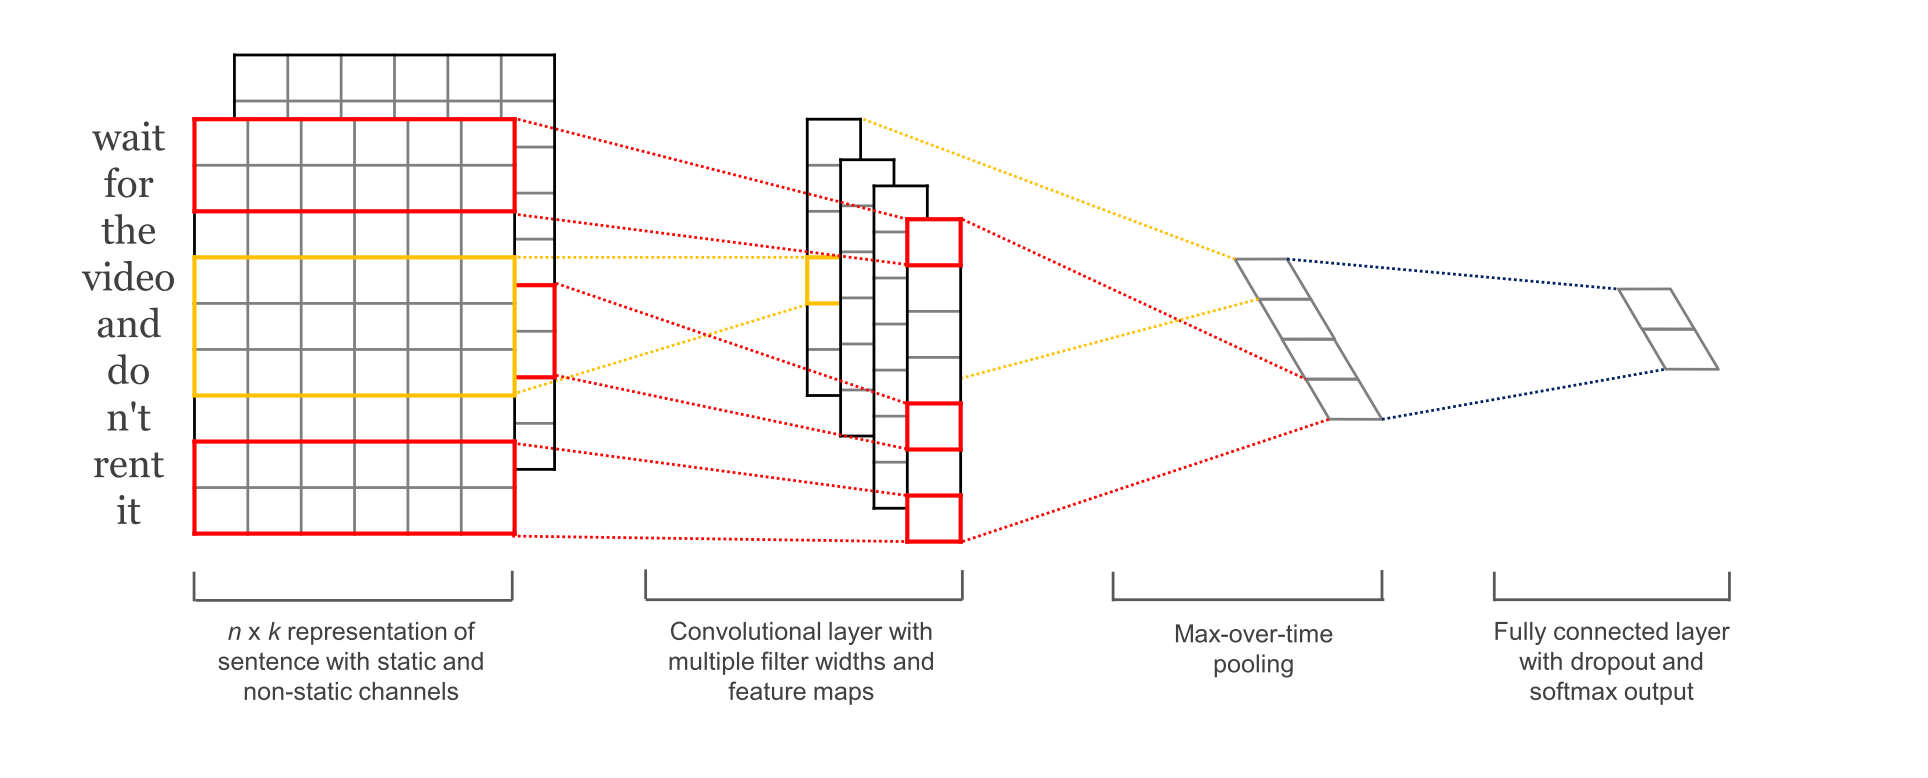

In [1]:
from IPython.display import Image
Image(filename='images/CNNsentence.png')

## Data

> The data is from a well-known dataset gathered from movie reviews on rottentomatoes.com. It includes almost 12,000 sentences and phrases that are categorized as positive, somewhat positive, neutral, somewhat negative, and negative.

[Recursive Deep Models for Semantic Compositionality
Over a Sentiment Treebank](http://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf). Socher, Richard et al. 2013.

## Getting Started

In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv('sst/datasetSentences.txt', sep="\t")

In [3]:
from preprocessing import clean_str, pad_sentences, float_to_class

df["sentence"] = df["sentence"] = df["sentence"].apply(lambda x: clean_str(x))

# Maximum length of all the sentences in the corpus
maxlen = len(max(df["sentence"], key = lambda x: len(x)))

df["sentence"] = df["sentence"].apply(lambda x: pad_sentences(x, maxlen))

In [4]:
df_ratings = pd.read_csv('sst/sentiment_labels.txt', sep="|")

In [5]:
df["sentiment class"] = df_ratings['sentiment values'].apply(lambda x: float_to_class(x))

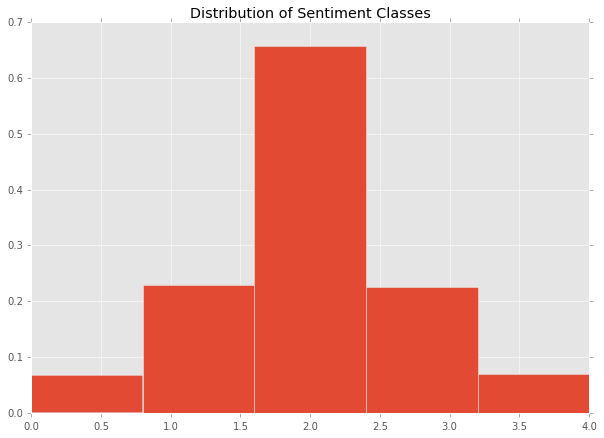

In [6]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline


df.hist(column="sentiment class",bins=5,normed=True, figsize=(10,7))
plt.title("Distribution of Sentiment Classes");

## Utilizing GloVe: Global Vectors for Word Representation

[GloVe: Global Vectors for Word Representation](http://nlp.stanford.edu/pubs/glove.pdf). Pennington, Jeffrey, Richard Socher, and Christopher Manning. 2014.

In [7]:
# Create dictionary for gloVe
gloVe = {}

with open('glove.6B/glove.6B.300d.txt', 'r') as f:
    for line in f:
        vec = line.split()
        gloVe[vec[0]] = [float(i) for i in vec[1:]]
f.close()

# Per the paper, pad the sentences that are less than the maximum sentence length with vectors of 0s
gloVe["<PAD/>"] = [0.0 for _ in range(300)]

In [8]:
# Paper recommends initializing words not present in gloVe to random vector

import itertools

all_words = list(itertools.chain.from_iterable(df['sentence']))

for word in all_words:
    if word not in gloVe:
        
        # Unlike the paper, words not appearing in set of pre-trained words are initialized to 0, not uniform random
        gloVe[word] = [0.0 for _ in range(300)]

> Note: the gloVe dataset is too large to fit in this GitHub repository; therefore, it will not be provided here. The reader is welcome to find it at the above site.

## Vectorize Dataset

In [9]:
# Create sentence tensor

data = np.zeros((len(df),53,300))
for elem in range(len(df)):
    data[elem] = np.array(*[[gloVe[word] for word in df["sentence"][elem]]])

# Create label tensor

labels = np.zeros((len(df),1))
for elem in range(len(df)):
     labels[elem] = df["sentiment class"][elem]

In [10]:
print("Sentence tensor size:", data.shape)
print("Label tensor size:", labels.shape)

Sentence tensor size: (11855, 53, 300)
Label tensor size: (11855, 1)


In [11]:
# Delete gloVe to free up memory

del gloVe

## Creating the Model

In [68]:
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape, Merge
from keras.utils import np_utils
from sklearn.cross_validation import train_test_split

labels = labels.reshape(11855, 1)
data = data.reshape(11855, 1, 53, 300)

xTrain, xTest, yTrain, yTest = train_test_split(data, labels, test_size=0.10)

# Per the paper, number of feature maps is 100
nb_feature_maps = 100
n_gram = 3
vector_size = 300
sentence_length = 53

model = Sequential()
model.add(Convolution2D(nb_feature_maps, n_gram, vector_size, input_shape=(1, 53, 300)))
model.add(MaxPooling2D(pool_size=(sentence_length - n_gram + 1, 1)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Activation('softmax'))

# Per the paper, optimizer is AdaDelta
model.compile(loss='sparse_categorical_crossentropy', optimizer='adadelta')

print('Fitting model...')

# Per the paper, minibatch size is 50
model.fit(xTrain, yTrain, nb_epoch=10, batch_size=50)

predictions = model.predict(xTrain, batch_size=50)

Fitting model...


INFO (theano.gof.compilelock): Waiting for existing lock by process '11671' (I am process '13912')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/user/.theano/compiledir_Darwin-15.4.0-x86_64-i386-64bit-i386-3.5.1-64/lock_dir


Epoch 1/10
10669/10669 [==============================] - 15s - loss: 3.1167    
Epoch 2/10
10669/10669 [==============================] - 13s - loss: 3.0019    
Epoch 3/10
10669/10669 [==============================] - 13s - loss: 2.9566    
Epoch 4/10
10669/10669 [==============================] - 13s - loss: 2.9359    
Epoch 5/10
10669/10669 [==============================] - 13s - loss: 2.9294    
Epoch 6/10
10669/10669 [==============================] - 13s - loss: 2.9026    
Epoch 7/10
10669/10669 [==============================] - 13s - loss: 2.8904    
Epoch 8/10
10669/10669 [==============================] - 13s - loss: 2.9019    
Epoch 9/10
10669/10669 [==============================] - 13s - loss: 2.9314    
Epoch 10/10
10669/10669 [==============================] - 13s - loss: 2.8770    


## Comparing Results

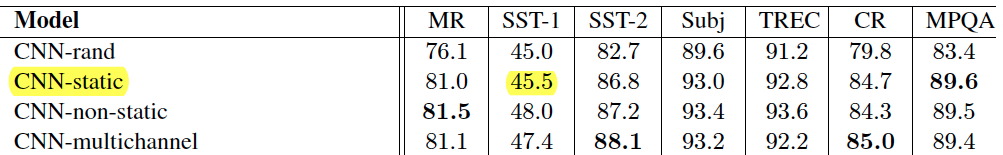

In [78]:
Image(filename='images/PaperResults.png')

In [69]:
predicted = model.predict_classes(xTest, batch_size=32)
actual = [int(x) for x in list(itertools.chain.from_iterable(yTest))]

1186/1186 [==============================] - 0s     


In [70]:
print("ACCURACY:",sum(predicted == actual) / len(actual))

ACCURACY: 0.466273187184


> My model as done at least as well as the model defined in the paper...

In [97]:
from collections import Counter

print("Distribution of predicted values:", Counter(predicted))
print()
print("Distribution of actual values:", Counter(actual))

Distribution of predicted values: Counter({2: 1007, 1: 117, 3: 49, 4: 9, 0: 4})

Distribution of actual values: Counter({2: 616, 1: 231, 3: 218, 4: 67, 0: 54})


In [95]:
print("Accuracy by guessing 2:", Counter(predicted)[2]/len(predicted))

Accuracy by guessing 2: 0.8490725126475548


> ...though still not as good as guessing, given the class imbalance.

## Future Ideas

> Try to mirror the paper by using different filter widths. My current attempt was not successful.

In [183]:
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape, Merge
from keras.utils import np_utils
from sklearn.cross_validation import train_test_split

labels = labels.reshape(11855, 1)
data = data.reshape(11855, 1, 53, 300)

xTrain, xTest, yTrain, yTest = train_test_split(data, labels)


nb_feature_maps = 51
n_gram = 3
vector_size = 300
sentence_length = 53

ngram_filters = [3, 4, 5, 6]
conv_filters = []

for n_gram in ngram_filters:
    conv_filters.append(Sequential())
    conv_filters[-1].add(Convolution2D(nb_feature_maps, n_gram, vector_size, input_shape=(1, 53, 300)))
#     conv_filters[-1].add(MaxPooling2D(pool_size=(sentence_length - n_gram + 1, 1)))
    conv_filters[-1].add(Flatten())

model2 = Sequential()
model2.add(Merge(conv_filters, mode='concat'))
model2.add(MaxPooling2D(pool_size=(nb_feature_maps, 1, sentence_length, vector_size)))
model2.add(Flatten())
model2.add(Dropout(0.5))
model2.add(Activation('softmax'))



model2.compile(loss='sparse_categorical_crossentropy', optimizer='adadelta')

print('Fitting model...')

model2.fit(xTrain, yTrain, nb_epoch=10, batch_size=32)

predictions2 = model2.predict(xTrain, batch_size=32)

Exception: Input 0 is incompatible with layer maxpooling2d_54: expected ndim=4, found ndim=2

> Accuracy metric is based on whether predicted class equals actual class. It would be interesting to alter the metric to acount for preditions that are approximately right. Misclassifying a "very positive" sentence as "very negative" isn't the same as classifying it as "somewhat positive."

## Conclusion

> Although I didn't use the exact model specified in the paper, the model I ultimately used produced fairly good results, at least on par with the paper's results. This demonstrates that although not customarily associated with NLP problems, CNNs have promise for basic NLP use cases like sentiment analysis.